<a href="https://colab.research.google.com/github/YonDraco/learn-pyimagesearch/blob/master/3_tf_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

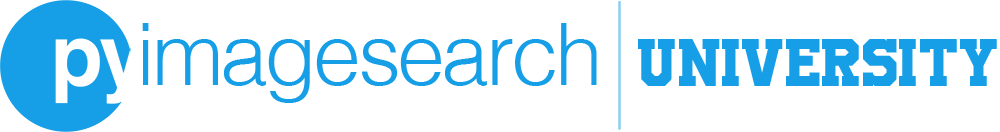

# Data augmentation with tf.data and TensorFlow
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch University](https://pyimg.co/university)** Jupyter Notebooks!

This notebook is associated with the [Data augmentation with tf.data and TensorFlow](https://www.pyimagesearch.com/2021/06/28/data-augmentation-with-tf-data-and-tensorflow/ ) blog post published on 2021-06-28.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch University Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2021 Adrian Rosebrock, PyImageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch University at https://pyimg.co/university today.*

### Download the code zip file

In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/tfdata-data-augmentation/tfdata-data-augmentation.zip
!unzip -qq tfdata-data-augmentation.zip
%cd tfdata-data-augmentation

--2021-08-25 17:39:26--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/tfdata-data-augmentation/tfdata-data-augmentation.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.218.153.225
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.218.153.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198715082 (190M) [binary/octet-stream]
Saving to: ‘tfdata-data-augmentation.zip’

tfdata-data-augment 100%[===================>] 189.51M  35.9MB/s    in 5.4s    

2021-08-25 17:39:32 (34.8 MB/s) - ‘tfdata-data-augmentation.zip’ saved [198715082/198715082]

/content/tfdata-data-augmentation


## Blog Post Code

### Import Packages

In [2]:
# import the necessary packages
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.data import AUTOTUNE
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import os

### Implementing data augmentation with tf.data and TensorFlow

In [3]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", required=True,
# 	help="path to input images dataset")
# ap.add_argument("-a", "--augment", type=bool, default=False,
# 	help="flag indicating whether or not augmentation will be applied")
# ap.add_argument("-t", "--type", choices=["layers", "ops"], 
# 	help="method to be used to perform data augmentation")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "dataset": "dataset/animals",
    "augment": 1,
    "type": "layers"
}

In [4]:
def load_images(imagePath):
	# read the image from disk, decode it, convert the data type to
	# floating point, and resize it
	image = tf.io.read_file(imagePath)
	image = tf.image.decode_jpeg(image, channels=3)
	image = tf.image.convert_image_dtype(image, dtype=tf.float32)
	image = tf.image.resize(image, (156, 156))

	# parse the class label from the file path
	label = tf.strings.split(imagePath, os.path.sep)[-2]
	
	# return the image and the label
	return (image, label)

In [5]:
def augment_using_layers(images, labels, aug):
	# pass a batch of images through our data augmentation pipeline
	# and return the augmented images
	images = aug(images)

	# return the image and the label
	return (images, labels)

In [6]:
def augment_using_ops(images, labels):
	# randomly flip the images horizontally, randomly flip the images
	# vertically, and rotate the images by 90 degrees in the counter
	# clockwise direction
	images = tf.image.random_flip_left_right(images)
	images = tf.image.random_flip_up_down(images)
	images = tf.image.rot90(images)

	# return the image and the label
	return (images, labels)

In [7]:
# set the batch size
BATCH_SIZE = 8

# grabs all image paths
imagePaths = list(paths.list_images(args["dataset"]))

# build our dataset and data input pipeline
print("[INFO] loading the dataset...")
ds = tf.data.Dataset.from_tensor_slices(imagePaths)
ds = (ds
	.shuffle(len(imagePaths), seed=42)
	.map(load_images, num_parallel_calls=AUTOTUNE)
	.cache()
	.batch(BATCH_SIZE)
)

[INFO] loading the dataset...


In [8]:
# check if we should apply data augmentation
if args["augment"]:
	# check if we will be using layers to perform data augmentation
	if args["type"] == "layers":
		# initialize our sequential data augmentation pipeline
		aug = tf.keras.Sequential([
			preprocessing.RandomFlip("horizontal_and_vertical"),
			preprocessing.RandomZoom(
				height_factor=(-0.05, -0.15),
				width_factor=(-0.05, -0.15)),
			preprocessing.RandomRotation(0.3)
		])

		# add data augmentation to our data input pipeline
		ds = (ds
			.map(lambda x, y: augment_using_layers(x, y, aug),
				num_parallel_calls=AUTOTUNE)
		)

	# otherwise, we will be using TensorFlow image operations to
	# perform data augmentation
	else:
		# add data augmentation to our data input pipeline
		ds = (ds
			.map(augment_using_ops, num_parallel_calls=AUTOTUNE)
		)

In [9]:
# complete our data input pipeline
ds = (ds
	.prefetch(AUTOTUNE)
)

# grab a batch of data from our dataset
batch = next(iter(ds))

[INFO] visualizing the first batch of the dataset...


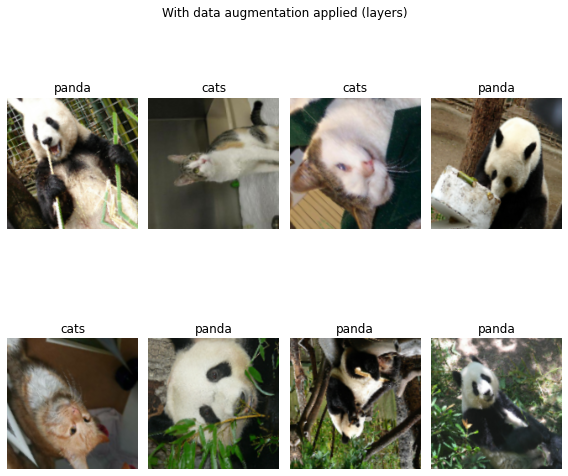

In [10]:
# initialize a figure
print("[INFO] visualizing the first batch of the dataset...")
title = "With data augmentation {}".format(
	"applied ({})".format(args["type"]) if args["augment"] else \
	"not applied")
fig = plt.figure(figsize=(BATCH_SIZE, BATCH_SIZE))
fig.suptitle(title)

# loop over the batch size
for i in range(0, BATCH_SIZE):
	# grab the image and label from the batch
	(image, label) = (batch[0][i], batch[1][i])

	# create a subplot and plot the image and label
	ax = plt.subplot(2, 4, i + 1)
	plt.imshow(image.numpy())
	plt.title(label.numpy().decode("UTF-8"))
	plt.axis("off")

# show the plot
plt.tight_layout()
plt.show()

### Implementing our data augmentation training script with tf.data


In [11]:
# define training hyperparameters
BATCH_SIZE = 64
EPOCHS = 50

# load the CIFAR-10 dataset
print("[INFO] loading training data...")
((trainX, trainLabels), (textX, testLabels)) = cifar10.load_data()

[INFO] loading training data...
170508288/170498071 [==============================] - 4s 0us/step


In [12]:
# initialize our sequential data augmentation pipeline for training
trainAug = Sequential([
	preprocessing.Rescaling(scale=1.0 / 255),
	preprocessing.RandomFlip("horizontal_and_vertical"),
	preprocessing.RandomZoom(
		height_factor=(-0.05, -0.15),
		width_factor=(-0.05, -0.15)),
	preprocessing.RandomRotation(0.3)
])

# initialize a second data augmentation pipeline for testing (this
# one will only do pixel intensity rescaling
testAug = Sequential([
	preprocessing.Rescaling(scale=1.0 / 255)
])

In [13]:
# prepare the training data pipeline (notice how the augmentation
# layers have been mapped)
trainDS = tf.data.Dataset.from_tensor_slices((trainX, trainLabels))
trainDS = (
	trainDS
	.shuffle(BATCH_SIZE * 100)
	.batch(BATCH_SIZE)
	.map(lambda x, y: (trainAug(x), y),
		 num_parallel_calls=tf.data.AUTOTUNE)
	.prefetch(tf.data.AUTOTUNE)
)

# create our testing data pipeline (notice this time that we are
# *not* apply data augmentation)
testDS = tf.data.Dataset.from_tensor_slices((textX, testLabels))
testDS = (
	testDS
	.batch(BATCH_SIZE)
	.map(lambda x, y: (testAug(x), y),
		num_parallel_calls=tf.data.AUTOTUNE)
	.prefetch(tf.data.AUTOTUNE)
)

In [14]:
# initialize the model as a super basic CNN with only a single CONV
# and RELU layer, followed by a FC and soft-max classifier
print("[INFO] initializing model...")
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",
	input_shape=(32, 32, 3)))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation("softmax"))

[INFO] initializing model...


In [15]:
# compile the model
print("[INFO] compiling model...")
model.compile(loss="sparse_categorical_crossentropy",
	optimizer="sgd", metrics=["accuracy"])

# train the model
print("[INFO] training model...")
H = model.fit(
	trainDS,
	validation_data=testDS,
	epochs=EPOCHS)

# show the accuracy on the testing set
(loss, accuracy) = model.evaluate(testDS)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))

[INFO] compiling model...
[INFO] training model...
Epoch 1/50
782/782 [==============================] - 26s 13ms/step - loss: 2.0576 - accuracy: 0.2524 - val_loss: 2.0489 - val_accuracy: 0.2563
Epoch 2/50
782/782 [==============================] - 10s 13ms/step - loss: 1.9210 - accuracy: 0.3171 - val_loss: 1.8945 - val_accuracy: 0.3189
Epoch 3/50
782/782 [==============================] - 10s 13ms/step - loss: 1.8666 - accuracy: 0.3361 - val_loss: 1.8294 - val_accuracy: 0.3469
Epoch 4/50
782/782 [==============================] - 10s 13ms/step - loss: 1.8252 - accuracy: 0.3521 - val_loss: 1.8049 - val_accuracy: 0.3482
Epoch 5/50
782/782 [==============================] - 10s 13ms/step - loss: 1.7918 - accuracy: 0.3623 - val_loss: 1.7975 - val_accuracy: 0.3568
Epoch 6/50
782/782 [==============================] - 11s 14ms/step - loss: 1.7663 - accuracy: 0.3711 - val_loss: 1.8758 - val_accuracy: 0.3036
Epoch 7/50
782/782 [==============================] - 11s 13ms/step - loss: 1.7468 - 

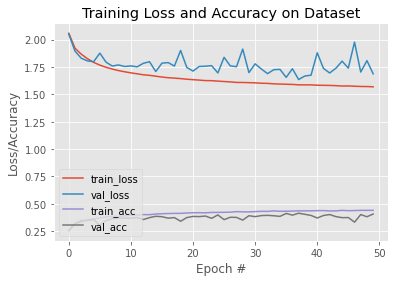

In [16]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [Data augmentation with tf.data and TensorFlow](https://www.pyimagesearch.com/2021/06/28/data-augmentation-with-tf-data-and-tensorflow/ ) published on 2021-06-28.

# Code License Agreement
```
Copyright (c) 2021 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```